In [1]:
#Utilizing Keras and Tensorflow to pull the information https://www.youtube.com/watch?v=H6du_pfuznE
#importing libraries

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



Pull Data

In [2]:
# Import data
appl_path = Path('../Resources/appl.csv')

# Read in data and index by date
df = pd.read_csv(
    appl_path, 
    index_col='date',     
    parse_dates=True, 
    infer_datetime_format=True
)
df.head()

,Unnamed: 0,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,,,
2015-05-27 00:00:00+00:00,0,AAPL,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
2015-05-28 00:00:00+00:00,1,AAPL,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2015-05-29 00:00:00+00:00,2,AAPL,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
2015-06-01 00:00:00+00:00,3,AAPL,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
2015-06-02 00:00:00+00:00,4,AAPL,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
# just pulling the last price, and reformating the df to only have the close price
df1=df.reset_index()['close']


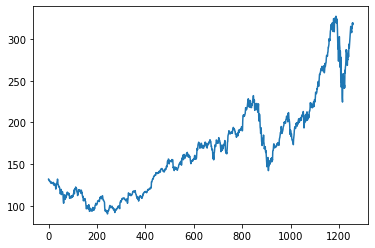

In [4]:
#ploting the close price
plt.plot(df1)

In [5]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler, try to transform the data to make it applicable

df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [6]:
#this transforms the current data into a more usable form, this changes it from 0 to 1 from the close prices, instead of the actual close, it will be values from 0 - 1 in the form of an array

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

#note that in order to use LSTM it needs to be in an array that is scalable 0 - 1 works the best

In [7]:
#transformed stock close prices
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [8]:
##splitting dataset into train and test split (this is your weights)
training_size=int(len(df1)*0.65) #65% is the training size of the total set
test_size=len(df1)-training_size #35% will be the test size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1] #

In [9]:
training_size,test_size

#timesteps = how many previous time iterations are needed to predict next one (Features), the more time steps, the more accurate the information will be

(817, 441)

In [10]:
# convert an array of values into a dataset matrix, function that takes and converts your dataset to what you want to train teh RNN asl, but you can update the timesteps accordingly
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape) #100 Features with 716 Values to reference

(716, 100)
(716,)


(None, None)

In [13]:
print(X_test.shape), print(ytest.shape) #100 Features with 340 items to test

(340, 100)
(340,)


(None, None)

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM, this need to be put in 3D due to the inputs
# batch_size,timesteps,data_dimension
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
#this is a stacked LSTM model

neurons = 50
timesteps = 100
data_dimension = 1
dense_layer = 1 # Another name for dense layer is Fully-connected layer. It's actually the layer where each neuron is connected to all of the neurons from the next layer.

model=Sequential()
model.add(LSTM(neurons,input_shape=(timesteps, data_dimension),return_sequences=True))
model.add(LSTM(neurons,return_sequences=True))
model.add(LSTM(neurons))
model.add(Dense(dense_layer))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
#training the model, currently set to silent mode, this will take time to process
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

In [18]:
tf.__version__

'2.6.0'

In [19]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [20]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics - Report Mean Square Error, this is for the data set comparison
math.sqrt(mean_squared_error(y_train,train_predict))

143.5635694134699

In [22]:
### Test Data RMSE - Report Mean Square Error
math.sqrt(mean_squared_error(ytest,test_predict))

241.540592584962

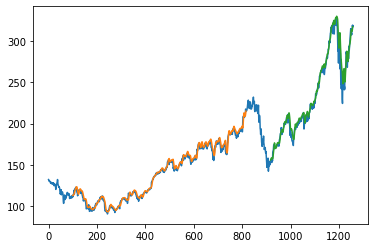

In [23]:
### Plotting 
# shift train predictions for plotting
look_back= timesteps #this is your timesteps from earlier
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#orange is training
#green is predicting the test data and verifying

In [24]:
len(test_data) #you need to take the previous timesteps in order to predict the next day, which is the timeseries logic

441

In [25]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [26]:
#converting the information to a list that has been scaled from 0 - 1 from earlier

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [27]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
prediction_days = 30

while(i<prediction_days): #this predicts the next 30 days
    
    if(len(temp_input)>timesteps): 
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.97829527]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.

In [28]:
day_new=np.arange(1,timesteps + 1)
day_pred=np.arange(timesteps + 1,timesteps + 1 + prediction_days)

In [29]:
len(df1)

1258

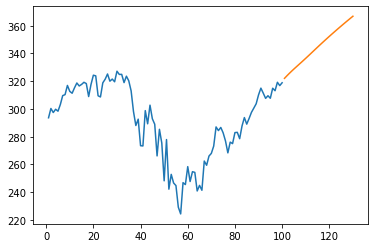

In [30]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output)) #this is the predicted data / output (Orange Line)

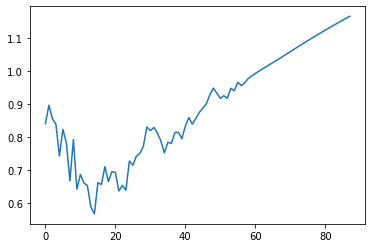

In [31]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

#this combines it together, and there is smoothing occurs

In [32]:
df3=scaler.inverse_transform(df3).tolist()

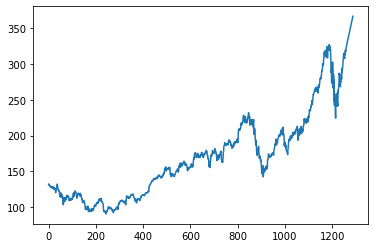

In [33]:
plt.plot(df3)